Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
#!pip install mne pyedflib seglearn tsfel

In [1]:
import itertools
import os

import mne
import numpy as np
import pandas as pd
import pyedflib

## Download the data

Commands to download and extract the data;
```sh
mkdir data
wget https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip -P data
# Only extract telemetry data
unzip data/sleep-edf-database-expanded-1.0.0.zip "sleep-edf-database-expanded-1.0.0/sleep-telemetry/*" -d data
```

# Create dataloader

## Some EDF loading funcs

In [2]:
def load_signals(file_path: str) -> list:
    edf = pyedflib.EdfReader(file_path)
    start = edf.getStartdatetime()
    data = []
    for ch_idx, sig_name, freq in zip(
        range(len(edf.getSignalLabels())),
        edf.getSignalLabels(),
        edf.getSampleFrequencies(),
    ):
        sig = edf.readSignal(chn=ch_idx)
        idx = pd.date_range(
            start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s")
        )
        data += [pd.Series(sig, index=idx, name=sig_name)]
    edf.close()
    return data

In [3]:
def load_annotations(annotation_file_path: str, psg_file_path: str) -> pd.DataFrame:
    annotations = mne.annotations.read_annotations(annotation_file_path)
    # Fore some hypnogram files there is an error when trying to get the start time
    # => Solution; get the start time from the psg file
    start_time = pyedflib.EdfReader(psg_file_path).getStartdatetime()
    df = pd.DataFrame()

    # Read the onset and set as index
    df["onset"] = annotations.onset
    df["onset"] = start_time + pd.TimedeltaIndex(df["onset"], unit="s")
    df = df.rename(columns={"onset": "start"})
    assert df["start"].is_unique
    df.set_index("start", inplace=True)

    # Read the duration and set as end time
    df["duration"] = annotations.duration
    df["end"] = df.index + pd.TimedeltaIndex(df["duration"], unit="s")
    df.drop(columns="duration", inplace=True)

    # Read the description
    df["description"] = annotations.description

    return df

In [4]:
def annotation_to_30s_labels(annotations: pd.DataFrame) -> pd.DataFrame:
    if not (annotations.index[1:] == annotations.end[:-1]).all():
        # There is a gap in the anotations
        diffs = (annotations.index[1:] - annotations.end[:-1]).dt.seconds
        gaps = diffs[diffs != 0]
        # The end time of gap_starts indicate the start of the gap
        gap_starts = annotations[:-1][~(annotations.index[1:] == annotations.end[:-1])]
        # The start time of gap_ends indicate the end of the gap
        gap_ends = annotations[1:][~(annotations.index[1:] == annotations.end[:-1])]
        for idx, gap in enumerate(gaps):
            assert gap > 0
            gap_start_label = gap_starts["description"].values[idx]
            gap_end_label = gap_ends["description"].values[idx]
            if gap_start_label == gap_end_label:
                annotations.loc[
                    annotations.index == gap_starts.index[idx], "end"
                ] += pd.Timedelta(gap, unit="s")
            else:
                print("Cannot fix gap")

    index = pd.date_range(
        start=annotations.index[0], end=annotations.end[-1], freq=pd.Timedelta("30s")
    )
    duration = (annotations.end - annotations.index).dt.seconds.values // 30
    labels = itertools.chain.from_iterable(
        [[l] * d for (l, d) in zip(annotations["description"], duration)]
    )
    df = pd.DataFrame({"label": labels}, index=index[:-1])
    df.index.name = "start"

    return df

## Load some data

In [5]:
data_folder = "data/sleep-edf-database-expanded-1.0.0/"

os.listdir(data_folder)

['sleep-telemetry']

In [6]:
os.listdir(data_folder + "sleep-telemetry")[:10]

['ST7111J0-PSG.edf',
 'ST7061J0-PSG.edf',
 'ST7051J0-PSG.edf',
 'ST7121JE-Hypnogram.edf',
 'ST7201J0-PSG.edf',
 'ST7241J0-PSG.edf',
 'ST7041J0-PSG.edf',
 'ST7132JR-Hypnogram.edf',
 'ST7022J0-PSG.edf',
 'ST7142JE-Hypnogram.edf']

In [7]:
len(os.listdir(data_folder + "sleep-telemetry"))

88

In [8]:
!du -hs data/sleep-edf-database-expanded-1.0.0/sleep-telemetry

1.1G	data/sleep-edf-database-expanded-1.0.0/sleep-telemetry


=> In total 88 files (44 PSG files - 44 hypnogram files) => 1.1 GB

In [9]:
# Create mapping between PSG file and its corresponding hypnogram file
sorted_files = sorted(os.listdir(data_folder + "sleep-telemetry"))
psg_hypnogram_dict = {p: h for p, h in zip(sorted_files[::2], sorted_files[1:][::2])}
psg_hypnogram_dict

{'ST7011J0-PSG.edf': 'ST7011JP-Hypnogram.edf',
 'ST7012J0-PSG.edf': 'ST7012JP-Hypnogram.edf',
 'ST7021J0-PSG.edf': 'ST7021JM-Hypnogram.edf',
 'ST7022J0-PSG.edf': 'ST7022JM-Hypnogram.edf',
 'ST7041J0-PSG.edf': 'ST7041JO-Hypnogram.edf',
 'ST7042J0-PSG.edf': 'ST7042JO-Hypnogram.edf',
 'ST7051J0-PSG.edf': 'ST7051JA-Hypnogram.edf',
 'ST7052J0-PSG.edf': 'ST7052JA-Hypnogram.edf',
 'ST7061J0-PSG.edf': 'ST7061JR-Hypnogram.edf',
 'ST7062J0-PSG.edf': 'ST7062JR-Hypnogram.edf',
 'ST7071J0-PSG.edf': 'ST7071JA-Hypnogram.edf',
 'ST7072J0-PSG.edf': 'ST7072JA-Hypnogram.edf',
 'ST7081J0-PSG.edf': 'ST7081JW-Hypnogram.edf',
 'ST7082J0-PSG.edf': 'ST7082JW-Hypnogram.edf',
 'ST7091J0-PSG.edf': 'ST7091JE-Hypnogram.edf',
 'ST7092J0-PSG.edf': 'ST7092JE-Hypnogram.edf',
 'ST7101J0-PSG.edf': 'ST7101JE-Hypnogram.edf',
 'ST7102J0-PSG.edf': 'ST7102JE-Hypnogram.edf',
 'ST7111J0-PSG.edf': 'ST7111JE-Hypnogram.edf',
 'ST7112J0-PSG.edf': 'ST7112JE-Hypnogram.edf',
 'ST7121J0-PSG.edf': 'ST7121JE-Hypnogram.edf',
 'ST7122J0-PS

In [10]:
# Make train-test split
train = sorted(psg_hypnogram_dict.keys())[:-8]
test = sorted(psg_hypnogram_dict.keys())[-8:]
len(train), len(test)

(36, 8)

In [11]:
file_folder = data_folder + "sleep-telemetry/"

In [12]:
data = load_signals(file_folder + train[0])
annotations = load_annotations(
    file_folder + psg_hypnogram_dict[train[0]], file_folder + train[0]
)

# EDA + pipeline (for 1 patient)

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

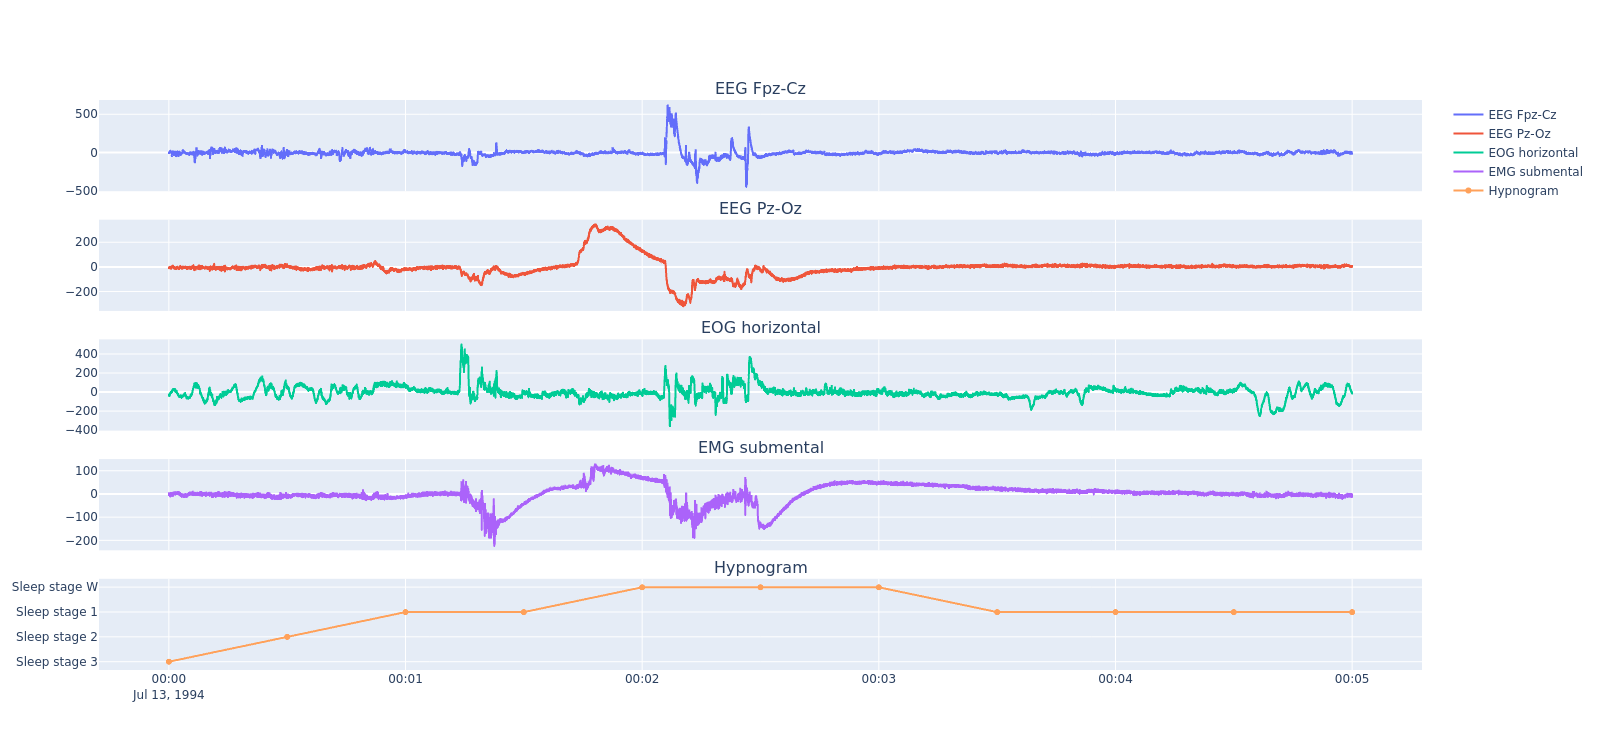

In [14]:
idxs = [s.name for s in data[:-1]]

fig = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=True,
    subplot_titles=idxs + ["Hypnogram"],
    vertical_spacing=0.05,
)

offset = 100 * 60 * 60  # 1h
nb_points = 100 * 60 * 5  # 5min

for idx, s in enumerate(data[:-1], 1):
    fig.add_trace(
        go.Scattergl(
            x=s.index[offset : offset + nb_points],
            y=s.values[offset : offset + nb_points],
            name=s.name,
        ),
        row=idx,
        col=1,
    )


fig.add_trace(
    go.Scattergl(
        x=annotation_to_30s_labels(annotations).index[60 * 2 : 60 * 2 + 5 * 2 + 1],
        y=annotation_to_30s_labels(annotations)["label"].values[
            60 * 2 : 60 * 2 + 5 * 2 + 1
        ],
        name="Hypnogram",
    ),
    row=5,
    col=1,
)

fig.show(renderer="png", height=150 * 5, width=1600)

## Process the signals

In [15]:
import sys

sys.path.append("../")

In [16]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


def clipper(sig, min_q=0, max_q=1):
    return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.53,
    highcut=15,
    fs=100,
)
emg_clipper = SeriesProcessor(
    function=clipper, series_names="EMG submental", min_q=0.02
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_clipper,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.53, 'highcut': 15, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	clipper {'min_q': 0.02} :  ('EMG submental',)
]

In [17]:
%%time
data_processed = process_pipe.process(data, return_all_series=False)

CPU times: user 334 ms, sys: 78.1 ms, total: 412 ms
Wall time: 366 ms


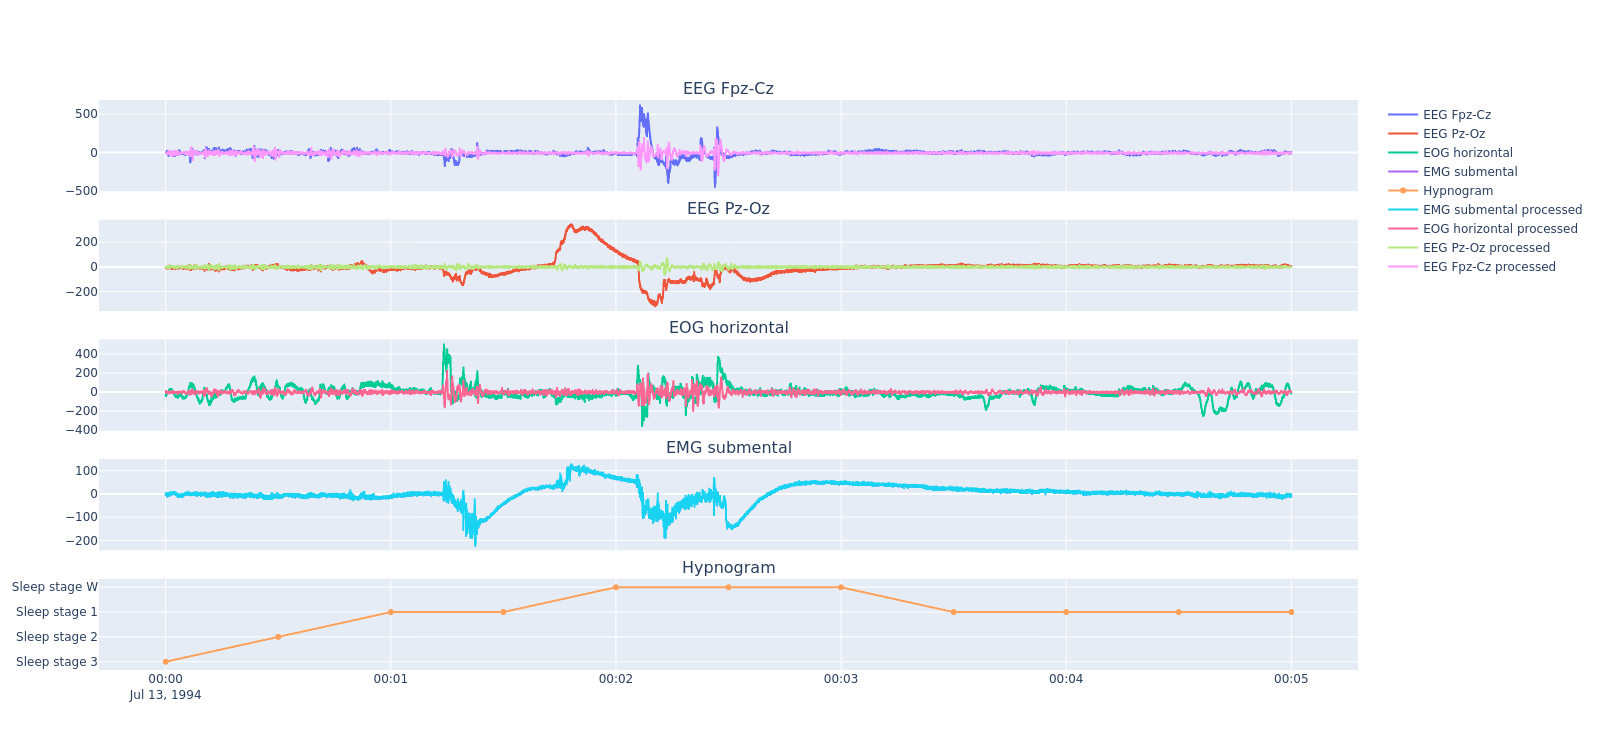

In [18]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scattergl(
            x=s.index[offset : offset + nb_points],
            y=s.values[offset : offset + nb_points],
            name=s.name + " processed",
        ),
        row=idx,
        col=1,
    )

fig.show(renderer="png", height=150 * 5, width=1600)

## Extract the features

In [19]:
from scipy.fft import fft
from seglearn.feature_functions import base_features, emg_features
from tsfel.feature_extraction.features import (
    wavelet_entropy, pk_pk_distance, entropy, neighbourhood_peaks, median_abs_deviation
)
from tsfel.feature_extraction.features import (
    # Some temporal features
    calc_centroid, auc, entropy, neighbourhood_peaks,
    # Some statistical features
    hist, ecdf, ecdf_percentile_count,
    # Some spectral features
    spectral_distance, fundamental_frequency, max_power_spectrum, 
    spectral_centroid, spectral_decrease, spectral_kurtosis,
    spectral_spread, human_range_energy, mfcc, fft_mean_coeff,
    wavelet_abs_mean, wavelet_std, wavelet_energy
)

from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_wrapper


# # Inspired by; https://github.com/jordan-bird/eeg-feature-generation/blob/master/code/EEG_feature_extraction.py
# def fft_feats(s: np.ndarray, freq, notch_f=50, ntop=10):
#     N = len(s)
#     T = freq / N

#     # Compute the (absolute values of the) FFT
#     # Extract only the first half of each FFT vector, since all the information
#     # is contained there (by construction the FFT returns a symmetric vector).
#     fft_values = np.abs(fft(s, axis=0))[0 : N // 2] * 2 / N

#     # Compute the corresponding frequencies of the FFT components
#     freqs = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)

#     # Remove mains frequency component(s)
#     indx = np.where(np.abs(freqs - notch_f) <= 1)
#     fft_values = np.delete(fft_values, indx, axis=0)
#     freqs = np.delete(freqs, indx)

#     # Extract top N frequencies
#     indx = np.argsort(fft_values, axis=0)[::-1]
#     indx = indx[:ntop]
#     topn_freqs = freqs[indx].flatten(order="F")

#     return topn_freqs

basic_feats = MultipleFeatureDescriptors(
    functions=[seglearn_wrapper(f, f_name) for f_name, f in base_features().items()],
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

emg_feats = MultipleFeatureDescriptors(
    functions=[seglearn_wrapper(f, f_name) for f_name, f in emg_features().items()],
    series_names=["EMG submental"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

eeg_feat = MultipleFeatureDescriptors(
    functions=[
#         FuncWrapper(
#         fft_feats, output_names=[f"freq_{i}" for i in range(1, 11)], freq=100
#         ),
        wavelet_entropy, pk_pk_distance, median_abs_deviation,
#         # Temporal
#         FuncWrapper(calc_centroid, fs=4), FuncWrapper(auc, fs=4),
#         FuncWrapper(neighbourhood_peaks, n=5, output_names="neighbourhood_peaks_n=5"),
#         # Statistical
#         FuncWrapper(hist, nbins=4, output_names=[f"hist{i}" for i in range(1,5)]),
#         FuncWrapper(ecdf, output_names=[f"ecdf{i}" for i in range(1,11)]),
#         FuncWrapper(ecdf_percentile_count, output_names=["ecdf_0.2", "ecdf_0.8"]),
#         # Spectral
        FuncWrapper(spectral_distance, fs=100), #FuncWrapper(fundamental_frequency, fs=100),
#         FuncWrapper(max_power_spectrum, fs=4), FuncWrapper(spectral_centroid, fs=4),
        FuncWrapper(spectral_decrease, fs=100), #FuncWrapper(spectral_kurtosis, fs=100),
        #FuncWrapper(spectral_spread, fs=100), 
        FuncWrapper(human_range_energy, fs=100),
#         FuncWrapper(mfcc, fs=100, num_ceps=6, output_names=[f"mfcc{i}" for i in range(1,7)]),
        FuncWrapper(fft_mean_coeff, fs=100, nfreq=8, output_names=[f"fft_mean_coeff_{i}" for i in range(8)]),
        FuncWrapper(wavelet_abs_mean, output_names=[f"wavelet_abs_mean_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_std, output_names=[f"wavelet_std_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_energy, widths=np.arange(1, 5), output_names=[f"wavelet_energy_{i}" for i in range(1,5)]),
    ],
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s"],
    strides="30s",
)

# eog_feat = MultipleFeatureDescriptors(
#     functions=FuncWrapper(fundamental_frequency, fs=100)
#     series_names=["EOG horizontal"]

feature_collection = FeatureCollection([basic_feats, emg_feats, eeg_feat])
feature_collection

EEG Fpz-Cz: (
	win: 30s   , stride: 30s: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mnx'], {}),
		FeatureDescriptor - func: FuncWrapper(wav

In [20]:
%%time
feats = feature_collection.calculate(data, return_df=True)
feats

CPU times: user 508 ms, sys: 424 ms, total: 932 ms
Wall time: 7.47 s


EEG Fpz-Cz__max__w=30s_s=30s  \
1994-07-12 23:00:30                    375.206006   
1994-07-12 23:01:00                    798.205457   
1994-07-12 23:01:30                    227.247757   
1994-07-12 23:02:00                    211.865959   
1994-07-12 23:02:30                     93.206372   
...                                           ...   
1994-07-13 08:56:00                  -2353.232009   
1994-07-13 08:56:30                  -2353.232009   
1994-07-13 08:57:00                  -2353.232009   
1994-07-13 08:57:30                  -2353.232009   
1994-07-13 08:58:00                  -2353.232009   

                     EEG Fpz-Cz__min__w=30s_s=30s  \
1994-07-12 23:00:30                  -2812.488555   
1994-07-12 23:01:00                   -376.304706   
1994-07-12 23:01:30                   -118.842703   
1994-07-12 23:02:00                   -107.123238   
1994-07-12 23:02:30                   -156.930965   
...                                           ...   
1994-07-13 08:56:00                  -2353.232009   
1994-07-13 08:56:30                  -2353.232009   
1994-07-13 08:57:00                  -2353.232009   
1994-07-13 08:57:30                  -2353.232009   
1994-07-13 08:58:00                  -2353.232009   

                     EEG Fpz-Cz__abs_energy__w=30s_s=30s  \
1994-07-12 23:00:30                         1.393122e+07   
1994-07-12 23:01:00                         8.378685e+07   
1994-07-12 23:01:30                         8.837607e+06   
1994-07-12 23:02:00                         3.720553e+06   
1994-07-12 23:02:30                         8.054288e+06   
...                                                  ...   
1994-07-13 08:56:00                         1.661310e+10   
1994-07-13 08:56:30                         1.661310e+10   
1994-07-13 08:57:00                         1.661310e+10   
1994-07-13 08:57:30                         1.661310e+10   
1994-07-13 08:58:00                         1.661310e+10   

                     EEG Fpz-Cz__pk_pk_distance__w=30s_s=30s  \
1994-07-12 23:00:30                              3187.694561   
1994-07-12 23:01:00                              1174.510163   
1994-07-12 23:01:30                               346.090460   
1994-07-12 23:02:00                               318.989196   
1994-07-12 23:02:30                               250.137337   
...                                                      ...   
1994-07-13 08:56:00                                 0.000000   
1994-07-13 08:56:30                                 0.000000   
1994-07-13 08:57:00                                 0.000000   
1994-07-13 08:57:30                                 0.000000   
1994-07-13 08:58:00                                 0.000000   

                     EEG Fpz-Cz__mean__w=30s_s=30s  \
1994-07-12 23:00:30                      -8.189831   
1994-07-12 23:01:00                     -14.405420   
1994-07-12 23:01:30                      -7.902704   
1994-07-12 23:02:00                       2.475981   
1994-07-12 23:02:30                      -7.832021   
...                                            ...   
1994-07-13 08:56:00                   -2353.232009   
1994-07-13 08:56:30                   -2353.232009   
1994-07-13 08:57:00                   -2353.232009   
1994-07-13 08:57:30                   -2353.232009   
1994-07-13 08:58:00                   -2353.232009   

                     EEG Fpz-Cz__mnx__w=30s_s=30s  \
1994-07-12 23:00:30                          29.0   
1994-07-12 23:01:00                          64.0   
1994-07-12 23:01:30                         233.0   
1994-07-12 23:02:00                         387.0   
1994-07-12 23:02:30                         175.0   
...                                           ...   
1994-07-13 08:56:00                           0.0   
1994-07-13 08:56:30                           0.0   
1994-07-13 08:57:00                           0.0   
1994-07-13 08:57:30                           0.0   
1994-07-13 08:58:00      

# Pipeline for all patients

In [21]:
from tqdm.auto import tqdm

df_feats = []
for psg_file, hypnogram_file in tqdm(psg_hypnogram_dict.items()):
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    )
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name
    df_feat["psg_file"] = psg_file
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

  0%|          | 0/44 [00:00<?, ?it/s]

In [22]:
df_feats.to_parquet("telemetry_features_v3.parquet")

In [21]:
df_feats = pd.read_parquet("telemetry_features_v3.parquet")

In [22]:
df_feats

EEG Fpz-Cz__min__w=30s_s=30s  \
1994-07-12 23:00:00                   -920.915417   
1994-07-12 23:00:30                   -263.206780   
1994-07-12 23:01:00                   -102.089503   
1994-07-12 23:01:30                   -125.458898   
1994-07-12 23:02:00                    -41.475728   
...                                           ...   
1994-09-16 07:42:00                    -64.584935   
1994-09-16 07:42:30                    -79.045928   
1994-09-16 07:43:00                   -182.971955   
1994-09-16 07:43:30                   -264.354724   
1994-09-16 07:44:00                  -2687.443846   

                     EEG Fpz-Cz__max__w=30s_s=30s  \
1994-07-12 23:00:00                    769.107829   
1994-07-12 23:00:30                    249.858810   
1994-07-12 23:01:00                    141.795611   
1994-07-12 23:01:30                     88.265500   
1994-07-12 23:02:00                     54.738822   
...                                           ...   
1994-09-16 07:42:00                     50.967380   
1994-09-16 07:42:30                    102.408404   
1994-09-16 07:43:00                    181.730929   
1994-09-16 07:43:30                    287.803678   
1994-09-16 07:44:00                   1111.666500   

                     EEG Fpz-Cz__max__w=1m_s=30s  \
1994-07-12 23:00:00                   769.107829   
1994-07-12 23:00:30                   249.858810   
1994-07-12 23:01:00                   141.795611   
1994-07-12 23:01:30                    88.265500   
1994-07-12 23:02:00                    54.738822   
...                                          ...   
1994-09-16 07:42:00                   102.408404   
1994-09-16 07:42:30                   181.730929   
1994-09-16 07:43:00                   287.803678   
1994-09-16 07:43:30                  1111.666500   
1994-09-16 07:44:00                  1111.666500   

                     EEG Fpz-Cz__abs_energy__w=30s_s=30s  \
1994-07-12 23:00:00                         4.935362e+06   
1994-07-12 23:00:30                         6.935646e+06   
1994-07-12 23:01:00                         2.519569e+06   
1994-07-12 23:01:30                         1.148557e+06   
1994-07-12 23:02:00                         4.127131e+05   
...                                                  ...   
1994-09-16 07:42:00                         4.974673e+05   
1994-09-16 07:42:30                         1.016686e+06   
1994-09-16 07:43:00                         3.684274e+06   
1994-09-16 07:43:30                         1.059374e+07   
1994-09-16 07:44:00                         9.131907e+07   

                     EEG Fpz-Cz__abs_energy__w=1m_s=30s  \
1994-07-12 23:00:00                        1.187101e+07   
1994-07-12 23:00:30                        9.455215e+06   
1994-07-12 23:01:00                        3.668126e+06   
1994-07-12 23:01:30                        1.561270e+06   
1994-07-12 23:02:00                        5.213993e+05   
...                                                 ...   
1994-09-16 07:42:00                        1.514153e+06   
1994-09-16 07:42:30                        4.700960e+06   
1994-09-16 07:43:00                        1.427802e+07   
1994-09-16 07:43:30                        1.019128e+08   
1994-09-16 07:44:00                        9.131907e+07   

                     EEG Fpz-Cz__mean__w=30s_s=30s  \
1994-07-12 23:00:00                       0.078109   
1994-07-12 23:00:30                      -0.812762   
1994-07-12 23:01:00                       0.712982   
1994-07-12 23:01:30                      -0.325129   
1994-07-12 23:02:00                       0.382195   
...                                            ...   
1994-09-16 07:42:00                      -0.007230   
1994-09-16 07:42:30                       0.002417   
1994-09-16 07:43:00                       0.458697   
1994-09-16 07:43:30                      -0.578976   
1994-09-16 07:44:00                       0.129774   

                     EEG Fpz-Cz__min__w=1m_

In [23]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]
    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats

EEG Fpz-Cz__min__w=30s_s=30s  \
1994-07-12 23:00:00                   -920.915417   
1994-07-12 23:00:30                   -263.206780   
1994-07-12 23:01:00                   -102.089503   
1994-07-12 23:01:30                   -125.458898   
1994-07-12 23:02:00                    -41.475728   
...                                           ...   
1994-09-16 07:42:00                    -64.584935   
1994-09-16 07:42:30                    -79.045928   
1994-09-16 07:43:00                   -182.971955   
1994-09-16 07:43:30                   -264.354724   
1994-09-16 07:44:00                  -2687.443846   

                     EEG Fpz-Cz__max__w=30s_s=30s  \
1994-07-12 23:00:00                    769.107829   
1994-07-12 23:00:30                    249.858810   
1994-07-12 23:01:00                    141.795611   
1994-07-12 23:01:30                     88.265500   
1994-07-12 23:02:00                     54.738822   
...                                           ...   
1994-09-16 07:42:00                     50.967380   
1994-09-16 07:42:30                    102.408404   
1994-09-16 07:43:00                    181.730929   
1994-09-16 07:43:30                    287.803678   
1994-09-16 07:44:00                   1111.666500   

                     EEG Fpz-Cz__max__w=1m_s=30s  \
1994-07-12 23:00:00                   769.107829   
1994-07-12 23:00:30                   249.858810   
1994-07-12 23:01:00                   141.795611   
1994-07-12 23:01:30                    88.265500   
1994-07-12 23:02:00                    54.738822   
...                                          ...   
1994-09-16 07:42:00                   102.408404   
1994-09-16 07:42:30                   181.730929   
1994-09-16 07:43:00                   287.803678   
1994-09-16 07:43:30                  1111.666500   
1994-09-16 07:44:00                  1111.666500   

                     EEG Fpz-Cz__abs_energy__w=30s_s=30s  \
1994-07-12 23:00:00                         4.935362e+06   
1994-07-12 23:00:30                         6.935646e+06   
1994-07-12 23:01:00                         2.519569e+06   
1994-07-12 23:01:30                         1.148557e+06   
1994-07-12 23:02:00                         4.127131e+05   
...                                                  ...   
1994-09-16 07:42:00                         4.974673e+05   
1994-09-16 07:42:30                         1.016686e+06   
1994-09-16 07:43:00                         3.684274e+06   
1994-09-16 07:43:30                         1.059374e+07   
1994-09-16 07:44:00                         9.131907e+07   

                     EEG Fpz-Cz__abs_energy__w=1m_s=30s  \
1994-07-12 23:00:00                        1.187101e+07   
1994-07-12 23:00:30                        9.455215e+06   
1994-07-12 23:01:00                        3.668126e+06   
1994-07-12 23:01:30                        1.561270e+06   
1994-07-12 23:02:00                        5.213993e+05   
...                                                 ...   
1994-09-16 07:42:00                        1.514153e+06   
1994-09-16 07:42:30                        4.700960e+06   
1994-09-16 07:43:00                        1.427802e+07   
1994-09-16 07:43:30                        1.019128e+08   
1994-09-16 07:44:00                        9.131907e+07   

                     EEG Fpz-Cz__mean__w=30s_s=30s  \
1994-07-12 23:00:00                       0.078109   
1994-07-12 23:00:30                      -0.812762   
1994-07-12 23:01:00                       0.712982   
1994-07-12 23:01:30                      -0.325129   
1994-07-12 23:02:00                       0.382195   
...                                            ...   
1994-09-16 07:42:00                      -0.007230   
1994-09-16 07:42:30                       0.002417   
1994-09-16 07:43:00                       0.458697   
1994-09-16 07:43:30                      -0.578976   
1994-09-16 07:44:00                       0.129774   

                     EEG Fpz-Cz__min__w=1m_

In [24]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats.loc[df_feats["label"] == "Movement time", "label"] = "Sleep stage W"

df_train = df_feats[df_feats.psg_file.isin(train)]
df_test = df_feats[df_feats.psg_file.isin(test)]
print(df_train.shape, df_test.shape)

(34917, 1178) (7922, 1178)


## EDA on labels

<AxesSubplot:>

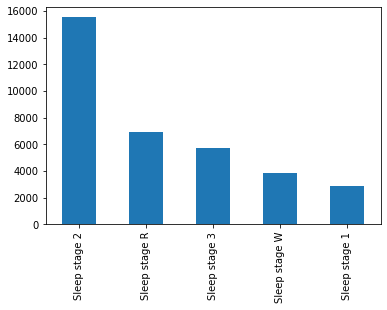

In [25]:
df_train["label"].value_counts().plot(kind="bar")

In [26]:
df_train["label"].value_counts()

Sleep stage 2    15526
Sleep stage R     6903
Sleep stage 3     5744
Sleep stage W     3855
Sleep stage 1     2889
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [27]:
import math

import matplotlib.pyplot as plt

skip_cols = ["psg_file", "label"]
feat_cols = df_train.drop(columns=skip_cols).columns

n_cols = 10
n_rows = math.ceil(len(feat_cols) / n_cols)
plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

for idx, col in enumerate(feat_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.boxplot(df_train[col].dropna(), vert=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# ML

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Logistic regression

Vanilla LR model, with some basic feature reduction

In [31]:
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(k=250)

from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", MinMaxScaler()),
    ]
)
x = pipe.fit_transform(df_train[feat_cols])
fit = bestfeatures.fit(x,df_train["label"])

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(feat_cols)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Col','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score')

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning:

Features [ 283  287  303  304  322  324  568  570  757  759  946  948 1135 1137] are constant.

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning:

invalid value encountered in true_divide



Col         Score
40        EEG Fpz-Cz__median_abs_deviation__w=1m_s=30s  10361.737173
22       EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s   9502.822752
144                         EEG Pz-Oz__mnx__w=2m_s=30s   9243.777068
111                         EEG Pz-Oz__mnx__w=1m_s=30s   8930.005824
810  EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_...   8471.740347
999  EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_...   8272.604796
621  EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_...   8029.151359
63                         EEG Pz-Oz__mnx__w=30s_s=30s   7946.540640
840             EEG Pz-Oz__mnx__w=30s_s=30s_shift=-30s   7589.198244
432  EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_...   7564.820524

In [32]:
selected = featureScores.nlargest(150,'Score')["Col"].values
selected

array(['EEG Fpz-Cz__median_abs_deviation__w=1m_s=30s',
       'EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s',
       'EEG Pz-Oz__mnx__w=2m_s=30s', 'EEG Pz-Oz__mnx__w=1m_s=30s',
       'EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_shift=-30s',
       'EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_shift=-1m',
       'EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_shift=30s',
       'EEG Pz-Oz__mnx__w=30s_s=30s',
       'EEG Pz-Oz__mnx__w=30s_s=30s_shift=-30s',
       'EEG Fpz-Cz__median_abs_deviation__w=30s_s=30s_shift=1m',
       'EEG Pz-Oz__mnx__w=30s_s=30s_shift=-1m',
       'EEG Pz-Oz__mnx__w=30s_s=30s_shift=30s',
       'EEG Pz-Oz__mnx__w=30s_s=30s_shift=1m',
       'EEG Pz-Oz__wavelet_entropy__w=1m_s=30s',
       'EEG Fpz-Cz__std__w=2m_s=30s', 'EEG Fpz-Cz__std__w=1m_s=30s',
       'EEG Fpz-Cz__std__w=30s_s=30s',
       'EEG Pz-Oz__wavelet_entropy__w=30s_s=30s',
       'EEG Pz-Oz__human_range_energy__w=1m_s=30s',
       'EEG Pz-Oz__human_range_energy__w=30s_s=30s',
       'EEG Pz-O

In [33]:
from sklearn.linear_model import LogisticRegression

# from sklearn.decomposition import PCA

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        (
            "lr",
            LogisticRegression(
#                 penalty="l1",
                solver="liblinear",
                class_weight="balanced",
                max_iter=300,
                random_state=42,
            ),
        ),
    ]
)

pipe.fit(df_train[selected], df_train["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    random_state=42, solver='liblinear'))])

In [34]:
preds = pipe.predict(df_test[selected])

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.63      0.60      0.62       801
Sleep stage 2       0.78      0.96      0.86      3530
Sleep stage 3       0.95      0.60      0.74      1059
Sleep stage R       0.93      0.73      0.82      1851
Sleep stage W       0.80      0.84      0.82       681

     accuracy                           0.81      7922
    macro avg       0.82      0.75      0.77      7922
 weighted avg       0.83      0.81      0.81      7922



In [35]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.7479502433144899


In [36]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.8114112597828831


### Grouped X-fold results for all data

In [37]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=10)
cv = gkfold.split(df_feats, groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[selected],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy"],
    cv=cv,
    n_jobs=25,
    return_train_score=True,
)

In [38]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))

10-FOLD: TEST
  MACRO F1:           0.784
  Balanced accuracy:  0.7939
  Accuracy:           0.8246


In [39]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8077
  Balanced accuracy:  0.8119
  Accuracy:           0.841


## LDA

Vanilla LDA model on all features

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis()),
    ]
)

pipe.fit(df_train[feat_cols], df_train["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])

In [41]:
preds = pipe.predict(df_test[feat_cols])

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.65      0.64      0.64       776
Sleep stage 2       0.86      0.94      0.90      3939
Sleep stage 3       0.92      0.67      0.78       912
Sleep stage R       0.94      0.78      0.85      1745
Sleep stage W       0.72      0.94      0.82       550

     accuracy                           0.85      7922
    macro avg       0.82      0.79      0.80      7922
 weighted avg       0.85      0.85      0.84      7922



In [42]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.7948178787999318


In [43]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.8467558697298662


### Predict for 1 patient

In [ ]:
sub_df = df_test[df_test.psg_file == df_test.psg_file[-1]]
pred = pipe.predict(sub_df[feat_cols])

fig = make_subplots(rows=2, shared_xaxes=True)

fig.add_trace(go.Scatter(x=sub_df.index, y=pred, name="prediction"))
fig.add_trace(go.Scatter(x=sub_df.index, y=sub_df.label, name="label"))

fig.add_trace(go.Scatter(x=sub_df.index, y=pred==sub_df.label, name="correct"), row=2, col=1)

fig.show(renderer="png", width=1600, height=700)

### Grouped X-fold results for all data

In [44]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=10)
cv = gkfold.split(df_feats, groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy"],
    cv=cv,
    n_jobs=25,
    return_train_score=True,
)

In [45]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))

10-FOLD: TEST
  MACRO F1:           0.7835
  Balanced accuracy:  0.775
  Accuracy:           0.8326


In [46]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8245
  Balanced accuracy:  0.8111
  Accuracy:           0.8591


## Benchmarking with sota

https://paperswithcode.com/sota/sleep-stage-detection-on-sleep-edf  
=> we keep up surprisingly well with the sota :)

**CONCLUSION**: Our macro F1 is ~ SOTA :)
> Disclaimer; we report results only on the telemetry dataset. The results when including the cassette dataset might be different